#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 3 - Deep Reinforcement Learning

## General overview
In this homework you will learn how to implement and test neural network models for solving reinforcement learning problems. The basic tasks for the homework will require to implement some extensions to the code that you have seen in the Lab. More advanced tasks will require to train and test your learning agent on a different environment. Given the higher computational complexity of RL, in this homework you don’t need to tune learning hyperparameters using search procedures and cross-validation; however, you are encouraged to play with model hyperparameters in order to find a satisfactory configuration.


## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework. If your code will be entirely included in a single Python notebook, just upload the notebook file.

As an example of more advanced libraries that can be used to implement deep RL agents, you can check this website:

https://stable-baselines.readthedocs.io/en/master/



## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length must not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional). Given the dynamical nature of RL problems, you can explore more sophisticated media for showing the results of your model (e.g., animated GIFs or short movies).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: extend the notebook used in Lab 07, in order to study how the exploration profile (either using eps-greedy or softmax) impacts the learning curve. Try to tune the model hyperparameters or tweak the reward function in order to speed-up learning convergence (i.e., reach the same accuracy with fewer training episodes).
*	3 pt: extend the notebook used in Lab 07, in order to learn to control the CartPole environment using directly the screen pixels, rather than the compact state representation used during the Lab (cart position, cart velocity, pole angle, pole angular velocity). This will require to change the “observation_space”.
*	3 pt: train a deep RL agent on a different Gym environment. You are free to choose whatever Gym environment you like from the available list, or even explore other simulation platforms:
https://gym.openai.com/envs 



## Deadline
The complete homework (source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.

# Install and Imports

In [ ]:
!pip install gym optuna

In [ ]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

import optuna
import plotly.graph_objects as go

# Enable gym environment rendering in Colab

In [ ]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       

In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

# Experience replay (Replay Memory)

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

## Network definition

In [ ]:
class DQN(nn.Module):

  def __init__(self, action_space_dim):
    super().__init__()

    self.cnn_model = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=3, padding=1),  # (N, 1, 600, 600)  -> (N, 10, 200, 200)
      nn.ReLU(),
      nn.AvgPool2d(kernel_size=2, stride=2),                                          # (N, 10, 200, 200) -> (N, 10, 100, 100)
      nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=3, padding=2), # (N, 10, 100, 100) -> (N, 20, 34, 34)
      nn.ReLU(),
      nn.AvgPool2d(kernel_size=2, stride=2)                                           # (N, 20, 34, 34)   -> (N, 20, 17, 17)
    )

    self.fc_model = nn.Sequential(
        nn.Linear(in_features=5780, out_features=160),                                # (N, 320)          -> (N, 160)
        nn.ReLU(),
        nn.Linear(in_features=160, out_features=action_space_dim),                    # (N, 160)          -> (N, action_space_dim)
    )

  def forward(self, x):
    x = self.cnn_model(x)
    x = x.view(x.size(0), -1)
    x = self.fc_model(x)
    x = x.squeeze()
    
    return x

In [ ]:
class DQN(nn.Module):

  def __init__(self, action_space_dim):
    super().__init__()

    self.cnn_model = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=3, padding=2),  # (N, 1, 100, 100)  -> (N, 10, 34, 34)
      nn.ReLU(),
      nn.AvgPool2d(kernel_size=2, stride=2),                                          # (N, 10, 34, 34)   -> (N, 10, 17, 17)
      nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=2, padding=0), # (N, 10, 17, 17)   -> (N, 20, 7, 7)
      nn.ReLU(),
      nn.AvgPool2d(kernel_size=2, stride=1)                                           # (N, 20, 7, 7)   -> (N, 20, 6, 6)
    )

    self.fc_model = nn.Sequential(
        nn.Linear(in_features=720, out_features=160),                                # (N, 720)          -> (N, 160)
        nn.ReLU(),
        nn.Linear(in_features=160, out_features=action_space_dim),                    # (N, 160)          -> (N, action_space_dim)
    )

  def forward(self, x):
    x = self.cnn_model(x)
    x = x.view(x.size(0), -1)
    x = self.fc_model(x)
    x = x.squeeze()
    
    return x

## Exploration Policy

### Epsilon-greedy policy


In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        state = state.unsqueeze(0)
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

### Softmax policy

In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        state = state.unsqueeze(0)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()          
    
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

### Exploration profile

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

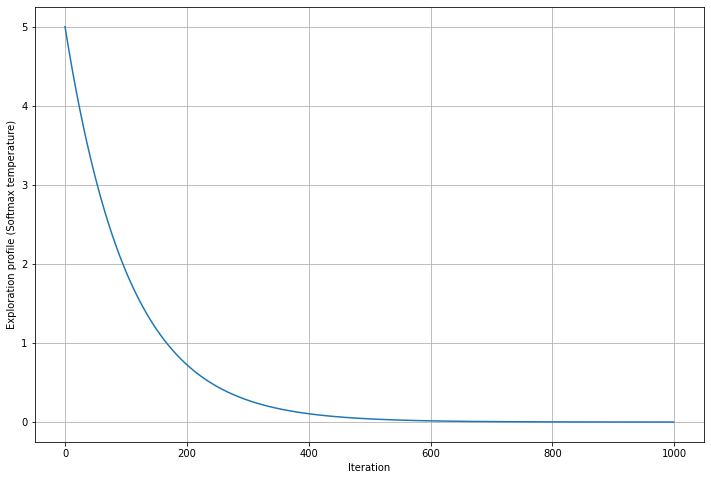

In [ ]:
### Define exploration profile
initial_value = 5
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

# Network update

## Initialization

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

# Get the shapes of the action space (action_space)
action_space_dim = env.action_space.n

print(f"ACTION SPACE SIZE: {action_space_dim}")

# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

ACTION SPACE SIZE: 2


## Update function

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

## Training loop

In [ ]:
def test(trial, policy_net):
  # Initialize the Gym environment
  env = gym.make('CartPole-v1') 
  env.seed(1) # Set a random seed for the environment (reproducible results)

  # This is for creating the output video in Colab, not required outside Colab
  env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

  test_score = 0
  num_iterations = 10
  # Let's try for a total of num_iterations episodes
  for num_episode in range(num_iterations): 
      # Reset the environment
      env.reset()
      # Get the initial state
      state = frame_processing(env.render(mode='rgb_array'))
      # Reset the score. The final score will be the total amount of steps before the pole falls
      score = 0
      done = False
      # Go on until the pole falls off or the score reach 490
      while not done:
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        _, reward, done, info = env.step(action)
        next_state = frame_processing(env.render(mode='rgb_array'))
        # Visually render the environment
        env.render()
        # Update the final score (+1 for each step)
        score += reward 
        # Set the current state for the next iteration
        state = next_state
        # Check if the episode ended (the pole fell down)
      # Print the final score
      print(f'\rTRIAL: {trial.number} - EPISODE {num_episode + 1} - FINAL SCORE: {score}', end='') 
      test_score += score

  env.close()

  test_score = test_score / num_iterations
  print(f'\rTRIAL: {trial.number} - FINAL TEST SCORE: {test_score}')

  return test_score

In [ ]:
import matplotlib.pyplot as plt
from skimage.transform import resize

def rgb2gray(img):
  return np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])

def scale(img, factor=6):
  return resize(img, (img.shape[0] // factor, img.shape[1] // factor))

def padding_height(img, height):
  edge_padding = int((height - img.shape[0]) / 2)
  return np.pad(img, ((edge_padding,), (0,)), constant_values=255)

def normalize(img):
  return img / 255

def shape(img):
  return np.reshape(img, (1, img.shape[0], img.shape[1]))

def frame_processing(img):
  return shape(normalize(padding_height(scale(rgb2gray(img)), 100)))

def frame_display(img):
  fig = plt.figure(figsize=(8,8))
  plt.imshow(img[0], cmap='Greys')

In [ ]:
def train(trial, config):
  # Initialize the Gym environment
  env = gym.make('CartPole-v1') 
  env.seed(0) # Set a random seed for the environment (reproducible results)

  # This is for creating the output video in Colab, not required outside Colab
  env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

  ### PARAMETERS
  gamma = 0.97   # gamma parameter for the long term reward
  replay_memory_capacity = 10000   # Replay memory capacity
  lr = 1e-2   # Optimizer learning rate
  target_net_update_steps = 10   # Number of episodes to wait before updating the target network
  batch_size = 128   # Number of samples to take from the replay memory for each update
  bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
  min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

  ### Define exploration profile
  initial_value = config['initial_value'] # Default: 5
  steepness_value = config['steepness_value'] # Default: 6
  num_iterations = config['num_iterations'] # Default: 1000
  exp_decay = np.exp(-np.log(initial_value) / num_iterations * steepness_value) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
  exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

  ### Initialize the replay memory
  replay_mem = ReplayMemory(replay_memory_capacity)    

  ### Initialize the policy network
  policy_net = DQN(action_space_dim)

  ### Initialize the target network with the same weights of the policy network
  target_net = DQN(action_space_dim)
  target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

  ### Initialize the optimizer
  optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

  ### Initialize the loss function (Huber loss)
  loss_fn = nn.SmoothL1Loss()

  score = 0
  scores = []
  for episode_num, tau in enumerate(exploration_profile):
    # Reset the environment
    env.reset()
    # Get the initial state
    state = frame_processing(env.render(mode='rgb_array'))
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      _, reward, done, info = env.step(action)
      next_state = frame_processing(env.render(mode='rgb_array'))

      # We apply a (linear) penalty when the cart is far from center
      #pos_weight = 1
      #reward = reward - pos_weight * np.abs(state[0]) 

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
        reward += bad_state_penalty
        next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
        update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
      print('\rUpdating target network...', end='')
      target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    if trial is None:
      print(f'\rEPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}', end='') # Print the final score
    else:
      print(f'\rTRIAL {trial.number} - EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}', end='') # Print the final score

    # Save the score in the scores list
    scores.append(score)

  env.close()

  test_score = test(trial, policy_net)

  if trial is not None:
    trial.set_user_attr('scores', scores)

  return test_score, scores

##Train

In [ ]:
from datetime import datetime

print("Datetime =", datetime.now())

results = []
num_iterations = 1000
optuna.logging.set_verbosity(0)

def optimize(trial):
  config = {
      'initial_value': 5, # Default: 5
      'steepness_value': 6, # Default: 6
      'num_iterations': num_iterations
  }

  test_score, scores = train(trial, config)

  return test_score

study = optuna.create_study(direction='maximize')
study.optimize(optimize, n_trials=1)

print("Datetime =", datetime.now())

Datetime = 2020-12-27 18:13:05.607946
TRIAL: 0 - FINAL TEST SCORE: 9.7
Datetime = 2020-12-27 20:29:25.670809


In [ ]:
# Display the videos
show_videos()


SHOWING VIDEO video/openaigym.video.7.1284.video000000.mp4



SHOWING VIDEO video/openaigym.video.7.1284.video000001.mp4



SHOWING VIDEO video/openaigym.video.7.1284.video000002.mp4



SHOWING VIDEO video/openaigym.video.7.1284.video000003.mp4



SHOWING VIDEO video/openaigym.video.7.1284.video000004.mp4



SHOWING VIDEO video/openaigym.video.7.1284.video000005.mp4



SHOWING VIDEO video/openaigym.video.7.1284.video000006.mp4



SHOWING VIDEO video/openaigym.video.7.1284.video000007.mp4



SHOWING VIDEO video/openaigym.video.7.1284.video000008.mp4



SHOWING VIDEO video/openaigym.video.7.1284.video000009.mp4


In [ ]:
def print_trials(trials):
  for trial in trials:
    print(f'Trial {trial.number}, Final value: {trial.value}, Hyperparameters: {trial.params}, Scores: {trial.user_attrs["scores"]}')

print_trials(study.trials)

Trial 0, Final value: 9.7, Hyperparameters: {}, Scores: [15, 25, 12, 14, 17, 14, 11, 20, 31, 30, 14, 23, 60, 36, 17, 12, 35, 27, 39, 10, 23, 35, 17, 17, 16, 29, 24, 23, 21, 26, 21, 17, 34, 18, 20, 23, 17, 11, 25, 21, 25, 15, 10, 21, 26, 14, 14, 33, 13, 20, 40, 14, 13, 21, 28, 13, 14, 41, 28, 34, 26, 34, 18, 14, 19, 20, 29, 18, 15, 14, 20, 11, 16, 13, 26, 24, 25, 24, 30, 29, 14, 17, 46, 10, 50, 15, 25, 50, 22, 37, 20, 13, 17, 14, 64, 25, 29, 21, 17, 29, 19, 31, 13, 11, 26, 11, 26, 22, 71, 18, 15, 17, 18, 19, 27, 18, 17, 26, 16, 24, 19, 14, 11, 17, 30, 15, 33, 18, 35, 20, 31, 19, 13, 18, 17, 12, 17, 16, 14, 22, 42, 13, 12, 57, 13, 20, 17, 19, 21, 20, 45, 13, 19, 22, 22, 14, 34, 14, 26, 14, 12, 20, 38, 17, 10, 29, 18, 37, 19, 12, 44, 31, 11, 25, 15, 14, 19, 14, 12, 13, 14, 21, 18, 35, 13, 23, 45, 35, 14, 12, 35, 14, 19, 19, 15, 21, 27, 17, 23, 19, 14, 15, 26, 19, 11, 17, 20, 33, 29, 16, 19, 24, 24, 30, 14, 21, 25, 29, 20, 25, 45, 30, 9, 19, 15, 56, 16, 20, 20, 15, 33, 16, 11, 15, 34, 9, 1

In [ ]:
def smooth_list(ls, num):
  return [sum(ls[i:i+num])/num for i in range(0, len(ls), num)]

trials = study.trials

In [ ]:
fig = go.Figure()
for idx in range(len(trials)):
  fig.add_trace(go.Scatter(y=trials[idx].user_attrs['scores'], name=f'Trial {idx}'))

fig.update_layout(
    title='Trials',
    xaxis_title='Episodes',
    yaxis_title='Score',
    height=800
)

fig.show()

In [ ]:
smoothing = 10

xaxis = []
for num_iteration in range(0, num_iterations//smoothing):
  label = str(num_iteration*smoothing+1) + '-' + str((num_iteration+1)*smoothing)
  xaxis.append(label)

fig = go.Figure()
for idx in range(len(trials)):
  smoothed_data = smooth_list(trials[idx].user_attrs['scores'], smoothing)
  fig.add_trace(go.Scatter(x=xaxis, y=smoothed_data, name=f'Trial {idx}'))

fig.update_layout(
    title='Trials smoothed',
    xaxis_title='Episodes',
    yaxis_title='Score',
    height=800
)

fig.show()